
# Проект: Оптимизация соотношения между скоростью и точностью распознавания рукописных цифр

В этом проекте я анализирую точность и производительность алгоритма kNN на данных рукописных цифр (MNIST).
Моя цель — не только достичь высокой точности, но и понять, как выбор модели влияет на опыт пользователя в приложении (то есть Retention, а в последствии LTV), например, при вводе сумм, номеров счетов для оплаты ЖКХ, номера телефона или реквезитов для переводов

# Задача
- **Формулировка задачи** пользователь вводит цифры вручную или через камеру; от качества распознавания зависит скорость и удобство.
- **Ключевые метрики:**
  - `Accuracy` — точность распознавания, влияет на ошибки _удовлетворенность_ пользователей
  - `Latency` — время задержки, влияет на отзывчивость интерфейса


In [1]:
!pip install scikit-learn

### Задача 1

Оптимизация модели классификации рукописных цифр [MNIST](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) для повышения точности предсказаний




Загрузка данных и разделение на обучающую и тестовую части.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

from sklearn import datasets
from sklearn.datasets import load_digits, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# фиксируем seed для воспроизводимости результатов
random_state = 42

In [3]:
digits = load_digits()

X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=random_state
)

Число соседей в модели kNN является необучаемым параметром т.е. гиперпараметром который выставляется вручную. Выбор оптимального значения $k$ важен, так как слишком маленькое значение может привести к переобучению, а слишком большое — к недообучению.

Построим график зависимости точности (`accuracy_score`) предсказания kNN от значения $k$ (от 1 до 20) для обучающей и тестовой выборок.

In [4]:
test_acc_score = []
train_acc_score = []

for k in range(1, 21):
  model = KNeighborsClassifier(n_neighbors=k, algorithm="brute")
  model.fit(X_train, y_train)

  y_pred_test = model.predict(X_test)
  test_acc_score.append(
    accuracy_score(y_pred_test, y_test)
  )

  y_pred_train = model.predict(X_train)
  train_acc_score.append(
    accuracy_score(y_pred_train, y_train)
  )


In [5]:
k_values = list(range(1, 21))

fig = px.line(
    x = k_values,
    y = [test_acc_score, train_acc_score],
    title='Зависимость точности предсказания kNN от значения k для обучающей и тестовой выборки',
    labels={'x':'число соседей k', 'value':'accuracy'},

)
fig.for_each_trace(
    lambda trace: trace.update(name="Тестовая выборка",
                               mode="lines+markers",
                               marker=dict(size=8, symbol="circle", line=dict(width=1, color="white")))

    if trace.name == "wide_variable_0"

    else trace.update(name="Обучающая выборка",
                      mode="lines+markers",
                      marker=dict(size=8, symbol="circle", line=dict(width=1, color="white")))
)
fig.update_layout(
    legend_title_text='Тип выборки'
)

fig.show()

Посмотрев на график появляется вопрос: почему при $k = 1$ на тренировочной выборке метрика качества составляет 100%?

**Ответ:**
В контексте kNN в случае algorithm="brute" "обучением" называется процесс запоминания всех данных, предоставленных для обучения. То есть модель просто сохраняет все точки данных вместе с их метками классов. Поэтому точность для каждого из значений при $k = 1$ (когда сосед это она сама) равна 100%

<!-- Внимание! Здесь находится специальная отметка. Ее нельзя удалять! Ответы на вопросы / выводы для предыдущего пункта(ов) пиши в ячейках выше! -->
<!-- cdb15caec1719ca7ba80d25b716879ca -->
Помимо числа соседей гиперпараметром модели также является *метрика расстояния* между объектами.

> По умолчанию используется *Евклидова метрика* ($L_2$), согласно которой расстояние между двумя точками $x_1 =(x_{11}, …, x_{1d})$ и $x_2=(x_{21},…,x_{2n})$ в $d$-мерном пространстве определяется как:
$$\rho(x_1, x_2) = \sqrt{\sum^d_{j=1}\left(x_{1j} - x_{2j}\right)^2}.$$
>
> Иногда в kNN имеет смысл использовать другие метрики, например *метрику Манхэттена* ($L_1$).
$$\rho(x_1, x_2) = \sum^d_{j=1} \left|x_{1j} - x_{2j}\right|.$$
>
> Выбор одной из них зависит от особенностей задачи и данных. В частности,
>
> * метрика Манхэттена менее чувствительна к выбросам, чем евклидово расстояние, что делает её полезной для данных с сильным шумом или при наличии аномалий;
>
> * в задачах с разреженными данными (например, текстовые данные, представленные в виде векторов) метрика Манхэттена может работать лучше, чем евклидово расстояние.

Проведем аналогичный эксперимент, используя в качестве гиперпараметра $L_1$-метрику. Выведем на одном графике зависимости точности (accuracy) от значения $k$ для обучающей и тестовой выборок для обоих метрик.

In [6]:
test_acc_score_L1 = []
train_acc_score_L1 = []

for k in range(1, 21):
  model = KNeighborsClassifier(n_neighbors=k, algorithm="kd_tree", metric='manhattan')
  model.fit(X_train, y_train)

  y_pred_test = model.predict(X_test)
  test_acc_score_L1.append(
    accuracy_score(y_pred_test, y_test)
  )

  y_pred_train = model.predict(X_train)
  train_acc_score_L1.append(
    accuracy_score(y_pred_train, y_train)
  )

In [7]:
k_values = list(range(1, 21))

fig = px.line(
    x = k_values,
    y = [test_acc_score_L1, train_acc_score_L1],
    title='Зависимость точности предсказания kNN от значения k для обучающей и тестовой выборки с метрикой Манхэтена',
    labels={'x':'число соседей k', 'value':'accuracy'},

)
fig.for_each_trace(
    lambda trace: trace.update(name="Тестовая выборка",
                               mode="lines+markers",
                               marker=dict(size=8, symbol="circle", line=dict(width=1, color="white")))

    if trace.name == "wide_variable_0"

    else trace.update(name="Обучающая выборка",
                      mode="lines+markers",
                      marker=dict(size=8, symbol="circle", line=dict(width=1, color="white")))
)
fig.update_layout(
    legend_title_text='Тип выборки'
)

fig.show()

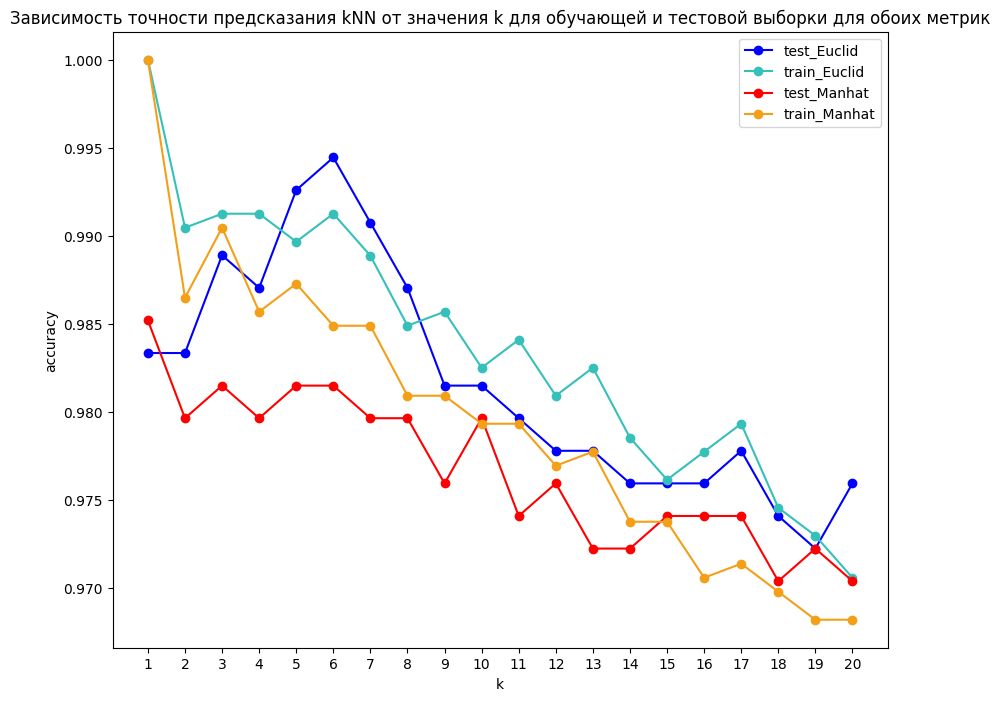

In [8]:
plt.figure(figsize = (10,8))
plt.plot(k_values, test_acc_score, marker='o', linestyle='-', color='b', label="test_Euclid")
plt.plot(k_values, train_acc_score, marker='o', linestyle='-', color='#35c0ba', label="train_Euclid")
plt.plot(k_values, test_acc_score_L1, marker='o', linestyle='-', color='r', label="test_Manhat")
plt.plot(k_values, train_acc_score_L1, marker='o', linestyle='-', color='#F39F18', label="train_Manhat")

plt.title('Зависимость точности предсказания kNN от значения k для обучающей и тестовой выборки для обоих метрик')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.legend()
plt.xticks(k_values)
plt.show()

 Почему смена метрики так сильно повлияла на характер кривых?

**Ответ:** Метрика определяет параметр определяющий "схожесть" объектов, поэтому точность будет отличаться.

**Выводы:** Заметим, в нашем случае Евклидова метрика оказалась лучше, чем Манхэтовкая, ее точность выше. Для этой метрики наиболее удачным $k$ будет $k = 6 \ (accuracy = 0.9944)$.

In [13]:

import time
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

latency_results = []
k_values = range(1, 21)

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k, algorithm="brute")
    model.fit(X_train, y_train)

    start_time = time.time()
    y_pred = model.predict(X_test)
    latency = time.time() - start_time

    acc = accuracy_score(y_test, y_pred)
    latency_results.append((k, acc, latency))


In [15]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
df = pd.DataFrame(latency_results, columns=['k', 'accuracy', 'latency'])

fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    subplot_titles=("Accuracy от k", "Latency от k"))

# Accuracy
fig.add_trace(
    go.Scatter(x=df["k"], y=df["accuracy"], mode='lines+markers', name='Accuracy'),
    row=1, col=1
)

# Latency
fig.add_trace(
    go.Scatter(x=df["k"], y=df["latency"], mode='lines+markers', name='Latency', marker_color='green'),
    row=2, col=1
)

fig.update_xaxes(title_text="Количество соседей k", row=2, col=1)
fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="Latency", row=2, col=1)

fig.update_layout(height=600, width=800, title_text="kNN: Точность и время отклика в зависимости от k")
fig.show()

In [17]:
fig = px.scatter(df, x='latency', y='accuracy', text='k',
                 title='Accuracy от Latency для kNN')
fig.update_traces(textposition='top center')
fig.show()

## Выводы на основе графиков:

### 1. **Оптимальное значение `k` по точности — `k = 6`**
- Достигается **максимальная точность 0.994**
- После `k = 6` наблюдается **переподгонка**: точность начинает снижаться, что типично для kNN (становится слишком много соседей, которые оказывают большое влияние)

---

### 2. **Latency постепенно растет**
Но для `k = 6` составляет < 0.014

---
Так как время задержки для наибольшей точности достаточно мало, то для наилучшего распознавания стоит остановится на `k = 6`. Таким образом можно распознавать цифры номера телефона при переводе по номеру телефона, считывая лишь фотографию номера, написанную даже от руки.